# Solution to Depletion Drive Reservoir using Tarner's Method

## Introdution 
------------
<font size =3.5>This project is targeted to calculate the future performance of a depletion drive reservoir system using a computer program that can reduce the time of computation and also give more in-depth analysis at one go. This notebook is the demonstration of the project and the steps of solving for depletion drive using Tarner's Method. Tarner's Method is based on the MBE trial and error technique that uses an iterative method to approximate the cumulative oil production at each required pressure stages of depletion.</font>

### Python for caluation
-----------------

Importing Useful libraries for calculation
* utils has all the supportive fonctions for Tarner's Method.
* pandas for tabulation of data

In [84]:
from utils import *
import pandas as pd
from collections import OrderedDict

## Sample Reservoir Data
-----------------------
Loading saved reservoir data

In [32]:
# Create new reservoir
# raw = create_new_reservoir()
# load reservoir
raw = load_reservoir()

Enter reservoir name:r3


In [87]:
d = {'Bo' : pd.Series(raw['data']['Bo']),
    'Pressure (psi)' : pd.Series(raw['data']['pressure']), 
      'Bg' : pd.Series(raw['data']['Bg']),
     'Rs' : pd.Series(raw['data']['Rs']),
     'Uo/Ug' : pd.Series(raw['data']['viscocity_ratio']),
     
    } 
pd.DataFrame(OrderedDict(d)).set_index("Pressure (psi)")

,Bo,Bg,Rs,Uo/Ug
Pressure (psi),,,,
2100.0,1.480,0.001283,1340.0,34.099998
1800.0,1.468,0.001518,1280.0,38.299999
1500.0,1.440,0.001853,1150.0,42.400002
1200.0,1.399,0.002365,985.0,48.799999
1000.0,1.360,0.002885,860.0,53.599998
700.0,1.287,0.004250,662.0,62.500000
400.0,1.202,0.007680,465.0,79.000000


## Permeability Ratio Curve
<hr>
The relative permeability data is required by the program in instantaneous GOR equation and that can be done interploation of the values. There are several different technique. A common technique is least square fit sometimes also called as curve fit. 
Curve fitting can be used to fit the So and Kg/Ko data and genterate a eqvivalent function for calcuation of Kg/Ko for the required value of So. 
Using this So and the equation formed using curve fitting (Kg.Ko vs So Plot.ipynb) can be used to calculate Kg/Ko.

$\frac{K_g}{K_o} = e^{F(S_o)} $

where ${F(S_o)} = A+B S_o+CS_o^2+...+NS_o^n$  where n is the Degree of  polynomial

In [36]:
d = { 'So (%)' : pd.Series(raw['data']['So']),
     'Kg/Ko' : pd.Series(raw['data']['rpr'])
    } 
pd.DataFrame(d)

,Kg/Ko,So (%)
0,0.010,83.5
1,0.023,80.0
2,0.070,75.0
3,0.195,70.0
4,0.408,65.0
5,0.860,60.0
6,1.800,55.0
7,3.300,50.0
8,6.300,45.0
9,12.000,40.0


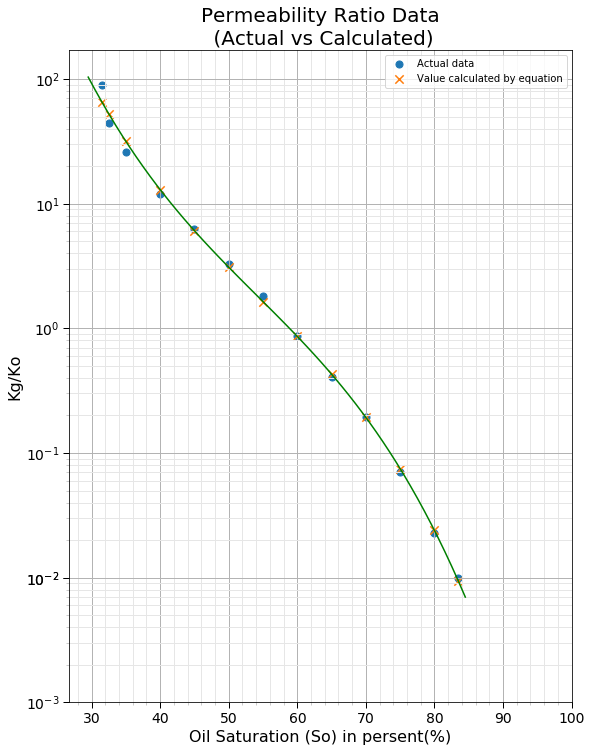

In [34]:
degree = 4
coeff = get_rpr_params(raw['data']["rpr"],raw['data']['So'],degree = degree)
raw['data']['K_coeff'] = coeff
plot_rpr_curve(raw['data']['So'],coeff,compare=True,rp=raw['data']["rpr"])

In [90]:
from IPython.display import Math
string =""+str(np.round(coeff[0],3))

for i in range(1,coeff.shape[0]):
    if coeff[i] > 0:
        string += '+'+str(np.round(coeff[i],3))+'S_o^'+str(i)
    else:
        string += str(np.round(coeff[i],3))+'S_o^'+str(i)
Math(r'\frac{K_g}{K_o} = e^{'+string+'}')

<IPython.core.display.Math object>

# Solving at Each Pressure Stage

In [95]:
# Solving for each pressure
saturation_th = raw['data']['sth']
raw['data']['Bt'] = cal_Bt(raw['data']['Bo'], raw['data']['Bg'],raw['data']['Rs'][0],raw['data']['Rs'])
raw['data']['Gp'] = np.zeros(raw['data']['pressure'].shape[0])
raw['data']['Np']= np.zeros(raw['data']['pressure'].shape[0])
raw['data']['gor']= np.zeros(raw['data']['pressure'].shape[0])
raw['data']['gor'][0] = raw['data']['Rs'][0]
for i in range(1,raw['data']['pressure'].shape[0]):
    raw['data'] = solve_for_Np(raw['data'], Swi = raw['data']["Swi"] , index = i, sth = saturation_th,Np=raw['data']['Np'][i-1])
# Gp_cal , Np_cal, Rp_cal

In [96]:
d = {'Pressure (psi)' : pd.Series(raw['data']['pressure']), 
      'Bg' : pd.Series(raw['data']['Bg']),
     'Rs' : pd.Series(raw['data']['Rs']),
     'Bo' : pd.Series(raw['data']['Bo']),
     'Uo/Ug' : pd.Series(raw['data']['viscocity_ratio']),
     'Cumulative Oil Production (MMSTB)' : pd.Series(np.round(raw['data']['Np']*raw['data']["oip"]/1e+6,3)),
     'Cumulative Gas Production (MMscf)' : pd.Series(np.round(raw['data']['Gp']*raw['data']["oip"]/1e+6,3)).cumsum() ,
     'Producing GOR (scf/STB)' : pd.Series(raw['data']['gor']),
     
    } 
df = pd.DataFrame(OrderedDict(d)).set_index("Pressure (psi)")
df

,Bg,Rs,Bo,Uo/Ug,Cumulative Oil Production (MMSTB),Cumulative Gas Production (MMscf),Producing GOR (scf/STB)
Pressure (psi),,,,,,,
2100.0,0.001283,1340.0,1.480,34.099998,0.000,0.000,1340.000000
1800.0,0.001518,1280.0,1.468,38.299999,3.760,6206.757,1961.210861
1500.0,0.001853,1150.0,1.440,42.400002,8.651,19486.984,3469.502370
1200.0,0.002365,985.0,1.399,48.799999,12.000,35691.431,6208.739136
1000.0,0.002885,860.0,1.360,53.599998,13.599,47614.590,8706.104498
700.0,0.004250,662.0,1.287,62.500000,15.361,66597.014,12829.581385
400.0,0.007680,465.0,1.202,79.000000,16.718,86147.731,16003.231837


In [99]:
# saving reservoir data
save_reservoir_data(raw)

## Reservoir Preformance

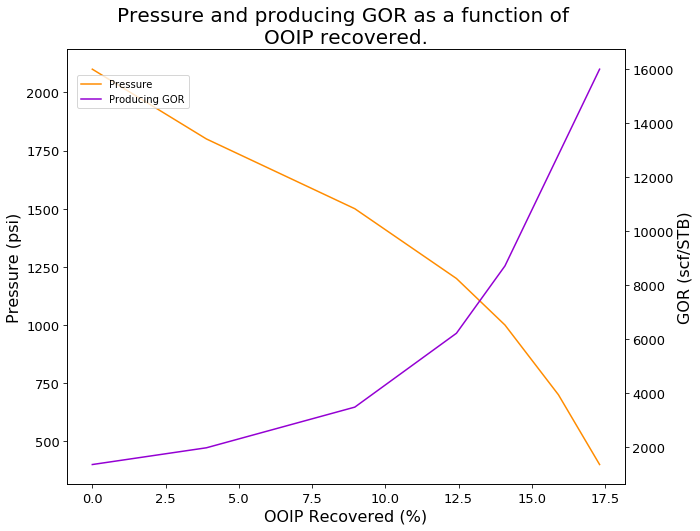

In [98]:
# Plots
f = plt.figure(figsize=(10,8))
ax1 = f.add_subplot(111)

ax1.plot(raw["data"]["Np"]*100,raw["data"]["pressure"],label = "Pressure",color="darkorange")
ax1.tick_params(size=4,labelsize=13)
ax1.set_ylabel("Pressure (psi)",fontsize =16)
ax1.set_xlabel("OOIP Recovered (%)",fontsize =16)

ax2 = ax1.twinx()
ax2.plot(raw["data"]["Np"]*100,raw["data"]["gor"],label = "Producing GOR",color="darkviolet")
ax2.tick_params(size=4,labelsize=13)
ax2.set_ylabel("GOR (scf/STB)",fontsize =16)

plt.title("Pressure and producing GOR as a function of \nOOIP recovered.",fontsize=20)
f.legend(loc = "upper left", bbox_to_anchor=(0.1,0.80))
plt.savefig("Pressure and producing GOR as a function of OOIP recovered.")
plt.show()

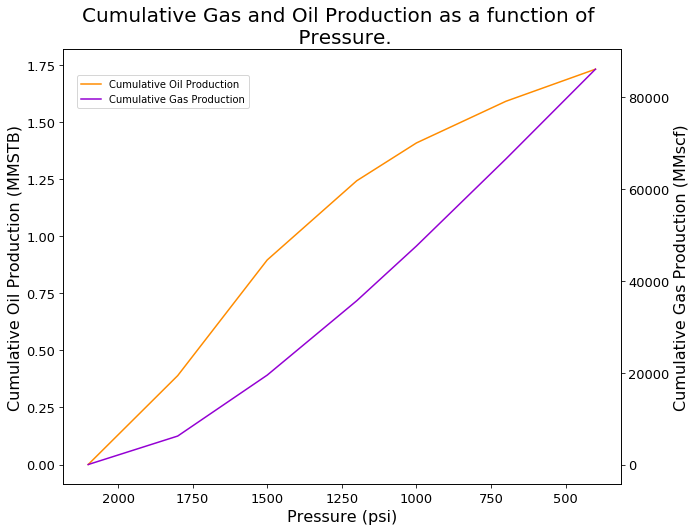

In [92]:
# Plots
f = plt.figure(figsize=(10,8))
ax1 = f.add_subplot(111)

ax1.plot(raw["data"]["pressure"],raw["data"]["Np"]*10,label = "Cumulative Oil Production",color="darkorange")
ax1.tick_params(size=4,labelsize=13)
ax1.set_ylabel("Cumulative Oil Production (MMSTB)",fontsize =16)
ax1.set_xlabel("Pressure (psi)",fontsize =16)
ax1.invert_xaxis()

ax2 = ax1.twinx()
ax2.plot(raw["data"]["pressure"],df["Cumulative Gas Production (MMscf)"],label = "Cumulative Gas Production",color="darkviolet")
ax2.tick_params(size=4,labelsize=13)
ax2.set_ylabel("Cumulative Gas Production (MMscf)",fontsize =16)


plt.title("Cumulative Gas and Oil Production as a function of \n Pressure.",fontsize=20)
f.legend(loc = "upper left", bbox_to_anchor=(0.1,0.80))
plt.savefig("Cumulative Gas and Oil Production as a function of Pressure.jpg")
plt.show()